<div style="background-color: lightgreen; border-radius: 5px; padding: 10px;">
    <h4>LDa Topic Modeling</h4>
    <p>...</p>
</div>

### Imports

In [3]:
from preprocessing_functions import *
from topic_modeling_functions import *

import warnings
warnings.filterwarnings('ignore')

C:\Users\diede\Personal Files [Local]\Applied Data Science\Thesis - CITYNET\venv_citynet3\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


### Import (Lemmatised) Paragraphs

In [4]:
new_data = False

if new_data:
    INPUT_DIR = "../../../../../data/clean/city_pair_paragraphs3/"
    BATCHES = [5, 10, 20, 30]
    POS = ["NOUN", "VERB", "ADJ"]
    ONLY_ENGLISH_WORDS = True
    sort_by_paragraphs_count = True
    merged_POS = True

    data_list = import_lemmatised_paragraphs(INPUT_DIR,
                                             POS,
                                             BATCHES,
                                             ONLY_ENGLISH_WORDS=ONLY_ENGLISH_WORDS,
                                             merged_POS=merged_POS,
                                             sort_by_paragraphs=sort_by_paragraphs_count)
    
    # Merge into single dataframe
    frames = [citypair['lemmatized_paragraphs'] for citypair in data_list]
    citypairs = [citypair['city_pair'] for citypair in data_list]

    result = pd.concat(frames) #, keys=citypairs)
    result.set_index('paragraph_id', inplace=True)
    result.sort_index(inplace=True)
    result.reset_index(inplace=True)
else:
    result = pd.read_csv("../../../../../data/clean/311k_paragraphs_clean.csv")

result

,paragraph_id,city_pair,paragraph,merged_POS
0,1,berlin_milan,"after his tenure in academia, he continued to ...","['tenure', 'academia', 'month', 'year', 'trave..."
1,2,berlin_milan,one of the astronomers selected for the search...,"['astronomer', 'search', 'priest', 'invitation..."
2,3,berlin_milan,there are plenty of air connections between ye...,"['plenty', 'air', 'connection', 'city', 'conne..."
3,4,berlin_milan,"since 2009, 'the brandery', an urban fashion s...","['fashion', 'year', 'language', 'monitor', 'ra..."
4,5,berlin_milan,when considering the commuter belts or metropo...,"['commuter', 'belt', 'area', 'datum', 'populat..."
...,...,...,...,...
310823,312682,warsaw_valencia,"since 2010, edelmann has intensified his conce...","['concert', 'activity', 'guest', 'performance'..."
310824,312683,warsaw_valencia,"born maria mokrzycka in lviv (now ukraine), sh...","['conservatory', 'debut', 'opera', 'opera', 't..."
310825,312684,warsaw_valencia,ayala was elected a fellow of the american aca...,"['fellow', 'art', 'science', 'member', 'societ..."
310826,312685,warsaw_valencia,o'conor was a co-founder of the dublin interna...,"['co', 'founder', 'competition', 'director', '..."


### Vectorize Documents

In [29]:
paragraphs = result.merged_POS
MIN_DF = 0.05
MAX_DF = 0.9

dictionary, corpus = vectorize(paragraphs,
                               MIN_DF=MIN_DF,
                               MAX_DF=MAX_DF)

### Train Single LDA Model

In [ ]:
N_TOPICS = 6
model_dict = train_lda_model(lemmatized_text=paragraphs,
                            dictionary=dictionary,
                            corpus=corpus,
                            MIN_DF=MIN_DF,
                            MAX_DF=MAX_DF,
                            N_TOPICS=N_TOPICS
                            # random_seed=0, should be added to allow the same results!
                            )

print(model_dict.keys())

### Load Desired Model

In [5]:
path = "../../../../../data/clean/lda_models/300k_paragraphs/lda_model_6topics_0_05min_0_9max/"
# path = os.getcwd() + '/' + 'lda_model_6_005min_09max'
# path = '../../../../../data/clean/lda_models/lda_model_6_005min_09max'
forced_path = os.path.abspath(path)

LOAD_VIS=True,
LOAD_DICT=True,
LOAD_TEXTS=True,
LOAD_COHERENCE_SCORE=True

if os.path.exists(forced_path):
    model_dict = load_lda_model(forced_path,
                           LOAD_VIS=LOAD_VIS,
                           LOAD_DICT=LOAD_DICT,
                           LOAD_TEXTS=LOAD_TEXTS,
                           LOAD_COHERENCE_SCORE=LOAD_COHERENCE_SCORE)
    print(model_dict.keys())
else:
    print('Path is invalid')

dict_keys(['lda_model', 'coherence_score', 'visualisation', 'texts', 'dictionary'])


### Visualisation

In [6]:
def visualise_topics(lda_model, corpus, dictionary, sort_topics=False):
    lda_conv = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(lda_model)
    vis = gensimvis.prepare(lda_conv, corpus, dictionary, sort_topics=False)
    
    print(vis.topic_order)
    
    return vis

In [1]:
pyLDAvis.enable_notebook()

if 'visualisation' not in model_dict.keys():
    vis = visualise_topics(model_dict['lda_model'], corpus, dictionary)
else:
    vis = model_dict['visualisation']

vis

NameError: name 'pyLDAvis' is not defined

### Get most relevant words per topic  
##### (used to create the topic vectors in the word embedding classification method)

In [39]:
all_topics = {}
num_terms = 15 # Adjust number of words to represent each topic
lambd = 0.2 # Adjust this accordingly based on tuning above

if not isinstance(vis, pyLDAvis._prepare.PreparedData):
    vis = visualise_topics(model_dict['lda_model'], corpus, dictionary)
    
for i in range(1,len(model_dict['lda_model'].get_topics())+1): #Adjust this to reflect number of topics chosen for final LDA model
    topic = vis.topic_info[vis.topic_info.Category == 'Topic'+str(i)].copy()
    topic['relevance'] = topic['loglift']*(1-lambd)+topic['logprob']*lambd
    all_topics['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values

In [42]:
pd.DataFrame(all_topics).T
# display(all_topics)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Topic 1,final,win,team,match,game,goal,club,league,champion,championship,season,score,round,tournament,football
Topic 2,exhibition,art,museum,gallery,exhibit,painting,collection,paint,portrait,artist,sculpture,fashion,design,contemporary,painter
Topic 3,war,embassy,army,diplomatic,ambassador,treaty,protest,force,mission,arrest,government,police,attack,party,minister
Topic 4,opera,festival,perform,orchestra,symphony,concert,music,film,sing,theatre,performance,role,premiere,tour,band
Topic 5,railway,route,line,operate,flight,station,service,airline,airport,train,passenger,speed,aircraft,rail,network
Topic 6,study,school,professor,university,graduate,bear,degree,research,college,teach,science,education,philosophy,father,doctorate


### Word-Topic Distribution

In [7]:
N_TOPICS = len(model_dict['lda_model'].get_topics())
MAX_WORDS = 8

for i in range(N_TOPICS):
    topic_words = model_dict['lda_model'].show_topic(i, topn=MAX_WORDS)
    print(i+1, [(x[0], round(x[1], 3)) for x in topic_words])
    print()

1 [('win', 0.035), ('final', 0.022), ('season', 0.019), ('club', 0.018), ('team', 0.018), ('play', 0.015), ('match', 0.014), ('game', 0.013)]

2 [('art', 0.035), ('work', 0.026), ('exhibition', 0.016), ('museum', 0.013), ('include', 0.011), ('gallery', 0.011), ('painting', 0.009), ('exhibit', 0.009)]

3 [('war', 0.008), ('german', 0.007), ('year', 0.006), ('time', 0.005), ('return', 0.005), ('city', 0.005), ('government', 0.005), ('leave', 0.004)]

4 [('opera', 0.038), ('festival', 0.024), ('perform', 0.021), ('music', 0.017), ('orchestra', 0.016), ('film', 0.014), ('include', 0.014), ('tour', 0.014)]

5 [('service', 0.016), ('city', 0.015), ('line', 0.012), ('company', 0.011), ('train', 0.011), ('railway', 0.01), ('station', 0.01), ('route', 0.01)]

6 [('study', 0.037), ('bear', 0.019), ('work', 0.017), ('school', 0.017), ('year', 0.015), ('university', 0.012), ('professor', 0.012), ('move', 0.009)]



### Document (=paragraphs) topic distribution

In [8]:
import pandas as pd

transformed_docs = model_dict['lda_model'].load_document_topics()
topic_distributions = pd.DataFrame([[x[1] for x in doc] for doc in transformed_docs], 
             columns=['topic_{}'.format(i+1) for i in range(N_TOPICS)])

In [25]:
topic_distributions.head(2)

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6
0,0.000765,0.001501,0.770121,0.001536,0.001327,0.224750
1,0.195772,0.498009,0.302968,0.001100,0.000950,0.001201


### Rename Topics

In [47]:
# Give Topics sensible names
topic_distributions_renamed_cols=topic_distributions.rename(columns = { 'topic_1': 'lda_sport',
                                        'topic_2': 'lda_art',
                                        'topic_3': 'lda_diplomacy',
                                        'topic_4': 'lda_entertainment',
                                        'topic_5': 'lda_transportation',
                                        'topic_6': 'lda_education'}, inplace = False)

topic_distributions_renamed_cols.head(2)

,lda_sport,lda_art,lda_diplomacy,lda_entertainment,lda_transportation,lda_education
0,0.000765,0.001501,0.770121,0.001536,0.001327,0.224750
1,0.195772,0.498009,0.302968,0.001100,0.000950,0.001201


### Topic Distributions

In [48]:
topic_distributions_renamed_cols.idxmax(axis="columns").value_counts()

lda_entertainment     65366
lda_diplomacy         57828
lda_education         55784
lda_art               52721
lda_transportation    47008
lda_sport             32121
dtype: int64

In [49]:
topic_distributions_renamed_cols.idxmax(axis="columns").value_counts(normalize=True)

lda_entertainment     0.210296
lda_diplomacy         0.186045
lda_education         0.179469
lda_art               0.169615
lda_transportation    0.151235
lda_sport             0.103340
dtype: float64

### Merge paragraphs with topic distributions

In [50]:
updated_results = pd.concat([result, topic_distributions_renamed_cols],
                  axis = 1)

In [51]:
 updated_results.head(2) # updated_results[topic_distributions_renamed_cols.columns]

,paragraph_id,city_pair,paragraph,merged_POS,lda_sport,lda_art,lda_diplomacy,lda_entertainment,lda_transportation,lda_education
0,1,berlin_milan,"after his tenure in academia, he continued to ...","['tenure', 'academia', 'month', 'year', 'trave...",0.000765,0.001501,0.770121,0.001536,0.001327,0.224750
1,2,berlin_milan,one of the astronomers selected for the search...,"['astronomer', 'search', 'priest', 'invitation...",0.195772,0.498009,0.302968,0.001100,0.000950,0.001201


### Get dominant topic and score of chunked dataframe

In [15]:
import numpy as np
nr_of_chunks = (len(updated_results) // 10000) + 1

chunked_dataframe = np.array_split(updated_results, nr_of_chunks)

In [16]:
# This may take a while

from tqdm.notebook import tqdm

for i, subdataframe in enumerate(tqdm(chunked_dataframe)):
    chunked_dataframe[i] = pd.concat([subdataframe, subdataframe[topic_distributions_renamed_cols.columns].agg(['idxmax','max'],axis=1)], axis=1)

  0%|          | 0/32 [00:00<?, ?it/s]

In [17]:
final_df = pd.concat(chunked_dataframe,axis=0)

In [52]:
final_df_renamed_cols = final_df.rename(columns = { 'idxmax': 'lda_dominant',
                                        'max': 'lda_dominant_score'}, inplace = False)

In [57]:
final_df_renamed_cols['lda_dominant'] = final_df_renamed_cols['lda_dominant'].replace({'lda_diplomatic':'lda_diplomacy'})

In [58]:
final_df_renamed_cols.head(2)

,paragraph_id,city_pair,paragraph,merged_POS,lda_sport,lda_art,lda_diplomacy,lda_entertainment,lda_transportation,lda_education,lda_dominant,lda_dominant_score
0,1,berlin_milan,"after his tenure in academia, he continued to ...","['tenure', 'academia', 'month', 'year', 'trave...",0.000765,0.001501,0.770121,0.001536,0.001327,0.224750,lda_diplomacy,0.770121
1,2,berlin_milan,one of the astronomers selected for the search...,"['astronomer', 'search', 'priest', 'invitation...",0.195772,0.498009,0.302968,0.001100,0.000950,0.001201,lda_art,0.498009


In [74]:
three_city_pairs = final_df_renamed_cols[final_df_renamed_cols['city_pair'].isin(['paris_milan', 'barcelona_manchester', 'warsaw_prague'])]

In [78]:
display(three_city_pairs.groupby('city_pair')['lda_dominant'].value_counts())

city_pair             lda_dominant      
barcelona_manchester  lda_sport              727
                      lda_transportation      43
                      lda_entertainment       37
                      lda_diplomacy           26
                      lda_education           17
                      lda_art                 16
paris_milan           lda_art               1091
                      lda_entertainment      705
                      lda_transportation     410
                      lda_diplomacy          366
                      lda_education          347
                      lda_sport              332
warsaw_prague         lda_diplomacy          352
                      lda_transportation     116
                      lda_education          113
                      lda_entertainment      113
                      lda_art                 81
                      lda_sport               41
Name: lda_dominant, dtype: int64

### Save document topic distribution

In [59]:
final_df_renamed_cols.to_csv('..\..\..\..\..\data\clean\lda_classified_30cities_435citypairs_311k_paragraphs.csv', index=False)

### Distribution of dominant topic scores

In [3]:
final_df_renamed_cols['lda_dominant_score'].value_counts(bins=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]).sort_values(ascending=False)

### Graphed density of the grouped topic scores

Text(0, 0.5, 'Density')

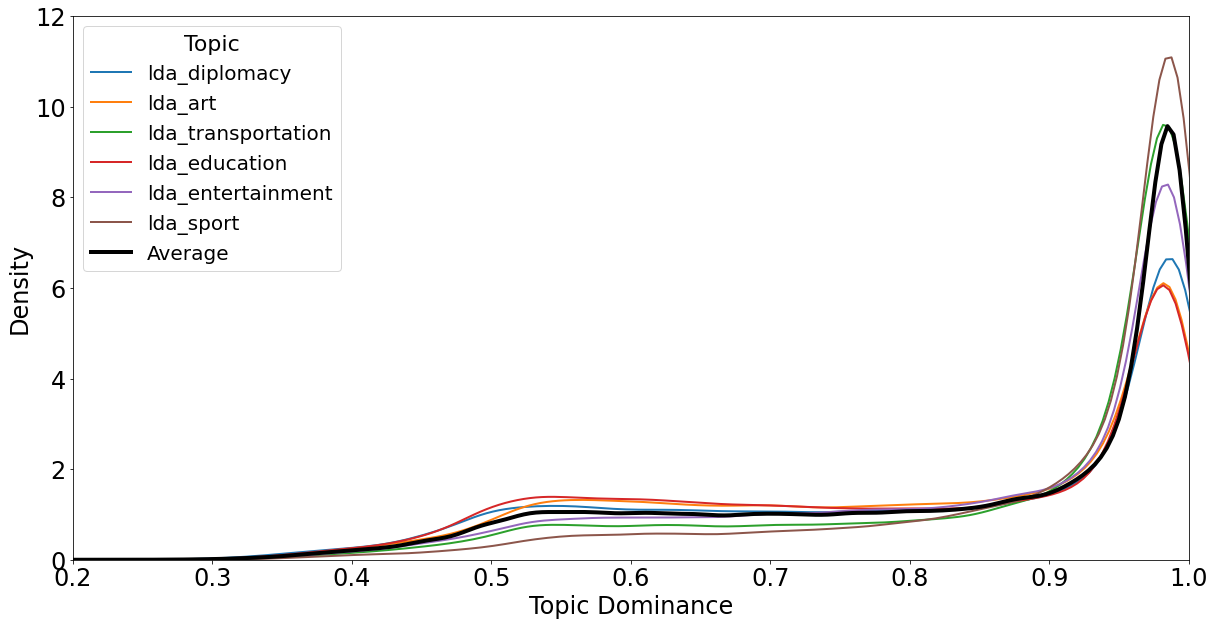

In [81]:
# !pip install seaborn
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

plt.figure(figsize=(20,10))

a = final_df_renamed_cols.groupby('lda_dominant')

# Iterate through the five airlines
for topic in final_df_renamed_cols['lda_dominant'].unique():
    b = a['lda_dominant_score'].get_group(topic)
    
    #     b.plot.density(color='green')
    # plt.title('Density plot for Speeding')
    # plt.show()
    
    sns.distplot(b, hist = False, kde = True,
                 kde_kws = {'linewidth': 2},
                 label = topic)
    
# Plot formatting
sns.distplot(final_df_renamed_cols['lda_dominant_score'], hist = False, kde = True,
                 kde_kws = {'linewidth': 4},
                 color = 'black',
                 label = 'Average')

plt.legend(prop={'size': 20}, title = 'Topic', title_fontsize=22)
# plt.title('Score Density of the dominant topics grouped by topic', fontsize=24)
plt.rc('axes', titlesize=24)
plt.rc('axes', labelsize=24)
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
plt.xlabel('Topic Dominance')
plt.ylim(0, 12)
plt.xlim(0.2, 1)
plt.ylabel('Density')

# Extras

### Train Multiple LDA Models

In [ ]:
# TOPIC_SELECTION = range(6, 7,1)
# list(TOPIC_SELECTION)

In [ ]:
"""
%%time

OUTPUT_DIR = '../../../../../data/clean/lda_models/300k_paragraphs/'
TOPIC_SELECTION = range(6, 7,1)
paragraphs = result.merged_POS
MIN_DF = 1
MAX_DF = 1.0
GET_COHERENCE_SCORE = True
N_ITERATIONS=1000

# Vectorization
dictionary, corpus = vectorize(paragraphs, MIN_DF=MIN_DF, MAX_DF=MAX_DF)

models = compare_lda_models(OUTPUT_DIR=OUTPUT_DIR,
                            TOPIC_SELECTION=TOPIC_SELECTION,
                            LEMMATIZED_TEXT=paragraphs,
                            DICTIONARY=dictionary,
                            CORPUS=corpus,
                            MIN_DF=MIN_DF,
                            MAX_DF=MAX_DF,
                            N_ITERATIONS=N_ITERATIONS,
                            # optimize_interval=10 by default
                            PATH_TO_MALLET=r'C:/mallet/bin/mallet.bat',
                            GET_COHERENCE_SCORE=GET_COHERENCE_SCORE,
                            COHERENCE='c_v')
"""

### Save LDA Model

In [ ]:
"""
import os

OUTPUT_DIR = os.getcwd()
MODEL_NAME = 'lda_model_6_005min_09max'
MODEL = model_dict['lda_model']
COHERENCE_SCORE = model_dict['coherence_score']
TEXTS = paragraphs
DICTIONARY = model_dict['dictionary']
CORPUS = model_dict['corpus']
VIS = vis

SAVE_VIS = True
SAVE_DICT = True
SAVE_TEXTS = True
SAVE_COHERENCE_SCORE = True

save_lda_model(MODEL=model['lda_model'],
                OUTPUT_DIR=OUTPUT_DIR,
                NAME=MODEL_NAME,
                COHERENCE_SCORE=COHERENCE_SCORE,
                DICTIONARY=DICTIONARY,
                CORPUS=CORPUS,
                TEXTS=TEXTS,
                VIS=VIS,
                SAVE_VIS=SAVE_VIS,
                SAVE_DICT=SAVE_DICT,
                SAVE_TEXTS=SAVE_TEXTS,
                SAVE_COHERENCE_SCORE=SAVE_COHERENCE_SCORE
              )
"""

### Load Multiple LDA Models

In [ ]:
"""
INPUT_DIR = '...'
LOAD_VIS = True
LOAD_DICT = True
LOAD_COHERENCE_SCORE = True


models = load_lda_models(INPUT_DIR=INPUT_DIR,
                         LOAD_VIS=LOAD_VIS,
                         LOAD_DICT=LOAD_DICT,
                         LOAD_COHERENCE_SCORE=LOAD_COHERENCE_SCORE)
"""

### Calculate Coherence Score

In [ ]:
""""
MODEL = None
LEMMATIZED_TEXT = None
DICTIONARY = None

if not None in [MODEL, LEMMATIZED_TEXT, DICTIONARY]:
    coherence_score = calculate_coherence_score(MODEL,
                                                LEMMATIZED_TEXT,
                                                DICTIONARY,
                                                COHERENCE='c_v')
"""